In [1]:
import sherpa
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup')
from config import C_COMMON, C_GRID, C_SINGLE, FILENAME

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# enable autoreload
%load_ext autoreload
%autoreload 2

2022-07-28 23:51:43.583375: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
columns = C_SINGLE
df = pd.read_csv(FILENAME, usecols=C_COMMON + columns).sort_values(['year', 'month'])

# we use the last 1/5 data as the heldout clean dataset. We do not use this fold for any use except for just reporting the result.
df_train_outer = df.query('fold != 4')
df_test_outer = df.query('fold == 4')
assert (sorted(df_test_outer['skn'].unique()) == sorted(df_train_outer['skn'].unique()))

# split the trainig data into 5 folds for inner cross validation
def assign_inner_fold(df, n_folds=5):
    # assign fold for each sample
    df_len_by_month = pd.DataFrame(df.groupby(by=['year', 'month']).size()).reset_index().rename({0: "len"}, axis=1)
    df_len_by_month = df_len_by_month.sort_values(['year', 'month'])
    df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()
    n_samples_total = df_len_by_month['cumsum'].iloc[-1]
    n_samples_per_fold = np.ceil(n_samples_total / n_folds)
    
    df_len_by_month['inner_fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)
    
    df_w_fold = pd.merge(left=df, right=df_len_by_month, left_on=['year', 'month'], right_on=['year', 'month'])
    
    return df_w_fold

df_inner_split = assign_inner_fold(df_train_outer)

In [264]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model

def define_model(
    input_dim=20,
    n_units=512,
    activation='selu',#selu
    learning_rate=0.0001,
    loss='mse'
):
    inputs = Input(shape=(input_dim))
    x = Dense(units=n_units, activation=activation)(inputs)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation)(x)
    x = Dropout(rate=0.5)(x)# serves as regularization
    # x = Dense(units=int(n_units/2), activation=activation)(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=[RootMeanSquaredError()]
    )
    return model


In [277]:
def prepare_dataset(df, skn, inner_fold, x_scale=True, y_scale=True):
    df_station = df[df['skn'] == skn]
    df_train = df_station[df_station['inner_fold'] != inner_fold]
    df_test = df_station[df_station['inner_fold'] == inner_fold]
    x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
    y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])
    
    if x_scale:
        x_scaler = MinMaxScaler()
        x_train = x_scaler.fit_transform(x_train)
        x_test = x_scaler.transform(x_test)
        
    if y_scale:
        y_scaler = MinMaxScaler(feature_range=(0,1))
        y_train = np.log(y_train + 1.)
        y_test = np.log(y_test + 1.)
    
        y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
        y_test = y_scaler.transform(y_test.reshape(-1, 1))
    else:
        y_scaler = None

    return x_train, x_test, y_train, y_test, y_scaler

In [280]:
skn = 54
# df_station = df_inner_split.query(f'skn == {skn}')
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        restore_best_weights=True,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.95,
        patience=10
    )
]
batch_size=192

x_train, x_test, y_train, y_test, y_scaler = prepare_dataset(df_inner_split, skn=skn, inner_fold=2, y_scale=True)
params = {'input_dim': 16,
 'n_units': 256,
 'learning_rate': 0.09599436158210974,
 'loss': 'mse'}
model = define_model(**params)
model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
y_pred = model.predict(x_test)

y_pred = y_scaler.inverse_transform(y_pred)
y_true = y_scaler.inverse_transform(y_test)

y_pred = np.power(np.e, y_pred) - 1
y_true = np.power(np.e, y_true) - 1
y_true = y_test
mean_squared_error(y_true, y_pred, squared=False)

Epoch 1/500
3/3 [==============================] - 1s 78ms/step - loss: 0.1826 - root_mean_squared_error: 0.4230 - val_loss: 0.1917 - val_root_mean_squared_error: 0.4378
Epoch 2/500
3/3 [==============================] - 0s 20ms/step - loss: 0.2971 - root_mean_squared_error: 0.5447 - val_loss: 0.3797 - val_root_mean_squared_error: 0.6162
Epoch 3/500
3/3 [==============================] - 0s 19ms/step - loss: 0.3670 - root_mean_squared_error: 0.6058 - val_loss: 0.3797 - val_root_mean_squared_error: 0.6162
Epoch 4/500
3/3 [==============================] - 0s 19ms/step - loss: 0.3627 - root_mean_squared_error: 0.6022 - val_loss: 0.3797 - val_root_mean_squared_error: 0.6162
Epoch 5/500
3/3 [==============================] - 0s 19ms/step - loss: 0.3656 - root_mean_squared_error: 0.6046 - val_loss: 0.3797 - val_root_mean_squared_error: 0.6162
Epoch 6/500
3/3 [==============================] - 0s 20ms/step - loss: 0.3678 - root_mean_squared_error: 0.6065 - val_loss: 0.3797 - val_root_mean_sq

0.27957300085156395

In [281]:
x_train, x_test, y_train, y_test, _ = prepare_dataset(df_inner_split, skn=skn, inner_fold=0, y_scale=False)
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
yhat = linear_regression.predict(x_test)
mean_squared_error(y_test, yhat, squared=False)

5.805417009638563

In [244]:
trial.parameters

{'n_units': 256,
 'learning_rate': 0.09599436158210974,
 'batch_size': 192,
 'loss': 'mse'}

In [ ]:
parameters = [
    sherpa.Choice('n_units', [256, 512, 1024]),
    sherpa.Continuous('learning_rate', [0.001, 0.1]),
    sherpa.Choice('batch_size', [64, 128, 192, 256, 512]),
    sherpa.Choice('loss', ['mse', 'mae'])
]
n_run = 1
alg = sherpa.algorithms.RandomSearch(max_num_trials=n_run)
study = sherpa.Study(parameters=parameters, algorithm=alg, lower_is_better=True)
dfs = []

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        restore_best_weights=True,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.95,
        patience=10
    )
]
dfs = []
for i, trial in enumerate(study):
    start = time.time()
    params = {
        'input_dim': len(columns),
        'n_units': trial.parameters['n_units'],
        'learning_rate': trial.parameters['learning_rate'],
        'loss': trial.parameters['loss']
    }
    batch_size = trial.parameters['batch_size']
    
    for skn in tqdm(df_inner_split['skn'].unique()):        
        ytest_station = []
        yhat_station = []
        for inner_fold in range(5):
            x_train, x_test, y_train, y_test, y_scaler = prepare_dataset(df_inner_split, skn=skn, inner_fold=inner_fold)
            model = define_model(**params)
            model.fit(x_train, y_train, epochs=500, validation_split=0.2, callbacks=callbacks,
                batch_size=batch_size,
                verbose=0
            )
            yhat = model.predict(x_test)
            # transform
            yhat = y_scaler.inverse_transform(yhat)
            yhat = np.power(np.e, yhat) - 1
            # transform
            y_test = y_scaler.inverse_transform(y_test)
            y_test = np.power(np.e, y_test) - 1
            
            # record the result
            yhat_station.extend(yhat)
            ytest_station.extend(y_test)
        
        mae_station = mean_absolute_error(ytest_station, yhat_station)
        rmse_station = mean_squared_error(ytest_station, yhat_station, squared=False)
        
        _ = pd.DataFrame([params])
        _['skn'] = [skn]
        _['batch_size'] = [batch_size]
        _['mae'] = [mae_station]
        _['rmse'] = [rmse_station]
        _['trial_id'] = [i]
        dfs.append(_)
#     pd.concat(dfs)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://10.100.11.207:8893 if on a cluster or
http://localhost:8893 if running locally.
-------------------------------------------------------
  0%|          | 0/24 [00:00<?, ?it/s]

 * Serving Flask app 'sherpa.app.app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


  4%|▍         | 1/24 [00:06<02:35,  6.76s/it]

In [283]:
pd.concat(dfs)

,input_dim,n_units,learning_rate,loss,skn,batch_size,mae,mse,trial_id
0,16,1024,0.097957,mse,54.0,256,29.453431,40.064505,0
0,16,1024,0.097957,mse,79.0,256,36.228678,50.187502,0
0,16,1024,0.097957,mse,338.0,256,24.166258,29.664231,0
0,16,1024,0.097957,mse,250.0,256,14.806082,15.067831,0
0,16,1024,0.097957,mse,267.0,256,18.489656,19.001440,0
0,16,1024,0.097957,mse,296.1,256,14.432521,14.680449,0
0,16,1024,0.097957,mse,311.0,256,9.134524,11.522283,0
0,16,1024,0.097957,mse,396.0,256,8.142749,10.036230,0
0,16,1024,0.097957,mse,400.0,256,10.048276,12.242109,0
0,16,1024,0.097957,mse,406.0,256,13.420642,14.718124,0


In [73]:
model = define_model_(
    input_dim=len(columns)
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        restore_best_weights=True,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.95,
        patience=10
    )
]

model.fit(
    x_train_scaled,
    y_train,
    # y_train_scaled,
    epochs=500,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/300
46/46 - 1s - loss: 38.9308 - root_mean_squared_error: 6.2395 - val_loss: 26.6914 - val_root_mean_squared_error: 5.1664
Epoch 2/300
46/46 - 0s - loss: 30.4772 - root_mean_squared_error: 5.5206 - val_loss: 29.0285 - val_root_mean_squared_error: 5.3878
Epoch 3/300
46/46 - 0s - loss: 29.3935 - root_mean_squared_error: 5.4216 - val_loss: 26.9698 - val_root_mean_squared_error: 5.1932
Epoch 4/300
46/46 - 0s - loss: 29.2583 - root_mean_squared_error: 5.4091 - val_loss: 26.8287 - val_root_mean_squared_error: 5.1796
Epoch 5/300
46/46 - 0s - loss: 29.8452 - root_mean_squared_error: 5.4631 - val_loss: 28.0896 - val_root_mean_squared_error: 5.3000
Epoch 6/300
46/46 - 0s - loss: 28.5969 - root_mean_squared_error: 5.3476 - val_loss: 26.9990 - val_root_mean_squared_error: 5.1961
Epoch 7/300
46/46 - 0s - loss: 29.5139 - root_mean_squared_error: 5.4327 - val_loss: 26.5525 - val_root_mean_squared_error: 5.1529
Epoch 8/300
46/46 - 0s - loss: 29.9113 - root_mean_squared_error: 5.4691 - val_loss

In [65]:
yhat_scaled = model.predict(x_test_scaled)
yhat = np.power(np.e, yhat_scaled) - 5
mean_squared_error(y_test, yhat, squared=False)

2035904468.8554227

In [74]:
yhat = model.predict(x_test_scaled)
mean_squared_error(y_test, yhat, squared=False)

5.361176043158557

In [67]:
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
yhat = linear_regression.predict(x_test)
mean_squared_error(y_test, yhat, squared=False)

5.4736767091311265

In [263]:
for skn in df_inner_split['skn'].unique():
    df_train = df_inner_split.query(f'(fold == {fold}) & skn == {skn}')
    df_test = df_inner_split.query(f'fold != {fold} & skn == {skn}')
    x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
    y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])

    x_scaler = MinMaxScaler()
    # y_scaler = MinMaxScaler()

    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    
    y_train_scaled = np.log(y_train + 5)
    y_test_scaled = np.log(y_test + 5)

    model = define_model_(
        input_dim=len(columns)
    )

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=50,
            restore_best_weights=True,
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.95,
            patience=10
        )
    ]

    model.fit(
        x_train_scaled,
        y_train_scaled,
        epochs=300,
        batch_size=64,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=0
    )

    yhat_scaled = model.predict(x_test_scaled)
    yhat = np.power(np.e, yhat_scaled) - 5
    rmse_nn = mean_squared_error(y_test, yhat, squared=False)


    linear_regression = LinearRegression()
    linear_regression.fit(x_train, y_train)
    yhat = linear_regression.predict(x_test)
    rmse_lr = mean_squared_error(y_test, yhat, squared=False)
    print(f"NN: {rmse_nn:.3f}, LR: {rmse_lr:.3f}, skn: {skn}")

NN: 5.893, LR: 6.190, skn: 54.0
NN: 6.264, LR: 6.505, skn: 79.0
NN: 4.954, LR: 4.873, skn: 338.0
NN: 2.042, LR: 2.125, skn: 250.0
NN: 2.348, LR: 2.326, skn: 267.0
NN: 2.102, LR: 1.715, skn: 296.1
NN: 1.521, LR: 1.508, skn: 311.0
NN: 2.378, LR: 1.754, skn: 396.0
NN: 2.067, LR: 1.862, skn: 400.0
NN: 2.016, LR: 1.980, skn: 406.0
NN: 2.814, LR: 1.983, skn: 410.0
NN: 2.563, LR: 2.484, skn: 485.0
NN: 2.369, LR: 2.309, skn: 703.0
NN: 6.085, LR: 5.473, skn: 718.0
NN: 2.570, LR: 2.472, skn: 770.0
NN: 5.751, LR: 4.539, skn: 783.0
NN: 6.970, LR: 5.822, skn: 784.0
NN: 2.065, LR: 1.922, skn: 965.0
NN: 3.535, LR: 3.613, skn: 1075.0
NN: 4.296, LR: 3.962, skn: 1117.0
NN: 3.968, LR: 3.909, skn: 1134.0
NN: 7.059, LR: 6.456, skn: 87.0
NN: 2.074, LR: 2.013, skn: 702.7
NN: 2.566, LR: 2.655, skn: 1020.1


<AxesSubplot:>

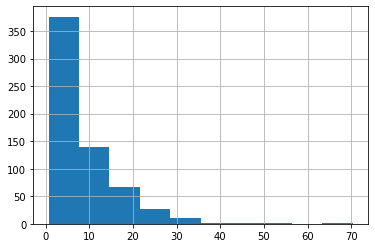

In [180]:
df_inner_split[df_inner_split['skn'] == 54]['data_in'].hist()

In [198]:
np.array(df_inner_split[df_inner_split['skn'] == 396]['data_in'])

array([7.830e+00, 3.800e+00, 2.280e+00, 1.750e+00, 2.300e-01, 1.000e-02,
       6.800e-01, 8.000e-02, 3.700e-01, 3.700e-01, 1.600e+00, 9.600e-01,
       5.340e+00, 3.340e+00, 3.700e-01, 2.500e-01, 2.000e-02, 2.400e-01,
       8.000e-02, 0.000e+00, 3.000e-02, 1.900e-01, 8.400e-01, 4.100e-01,
       7.640e+00, 6.100e-01, 1.220e+00, 5.680e+00, 2.500e-01, 0.000e+00,
       2.000e-01, 1.440e+00, 7.000e-02, 1.700e-01, 1.018e+01, 8.660e+00,
       2.270e+00, 6.410e+00, 8.350e+00, 9.000e-02, 0.000e+00, 9.000e-02,
       8.000e-02, 7.000e-02, 9.000e-02, 3.050e+00, 1.300e-01, 1.970e+00,
       5.570e+00, 5.000e-01, 6.300e-01, 1.200e-01, 3.000e-02, 2.000e-02,
       3.900e-01, 1.000e-01, 8.000e-02, 1.540e+00, 5.800e-01, 3.900e-01,
       7.400e-01, 1.900e+00, 1.770e+00, 4.700e-01, 5.500e-01, 0.000e+00,
       3.000e-02, 1.000e-02, 0.000e+00, 1.900e-01, 4.900e-01, 1.990e+00,
       5.400e-01, 9.200e-01, 3.090e+00, 1.550e+00, 5.600e-01, 3.000e-02,
       6.100e-01, 2.000e-01, 2.000e-02, 2.600e-01, 

In [197]:
np.log(np.array(df_inner_split[df_inner_split['skn'] == 396]['data_in']) + 5)

array([2.55178618, 2.17475172, 1.98513086, 1.9095425 , 1.65441128,
       1.61143592, 1.73695123, 1.62531126, 1.68082791, 1.68082791,
       1.88706965, 1.78507048, 2.33601987, 2.12106322, 1.68082791,
       1.65822808, 1.61342993, 1.6563215 , 1.62531126, 1.60943791,
       1.61541998, 1.6467337 , 1.7647308 , 1.68824909, 2.53686639,
       1.72455072, 1.82776991, 2.36837283, 1.65822808, 1.60943791,
       1.64865863, 1.86252854, 1.62334082, 1.64287269, 2.71997877,
       2.61447185, 1.98375629, 2.43449016, 2.59151638, 1.62727783,
       1.60943791, 1.62727783, 1.62531126, 1.62334082, 1.62727783,
       2.08567209, 1.63510566, 1.94161522, 2.3580198 , 1.70474809,
       1.72810944, 1.63315444, 1.61541998, 1.61342993, 1.68454538,
       1.62924054, 1.62531126, 1.87793717, 1.71918878, 1.68454538,
       1.74745921, 1.93152141, 1.91250109, 1.69927862, 1.71379793,
       1.60943791, 1.61541998, 1.61143592, 1.60943791, 1.6467337 ,
       1.70292826, 1.94448056, 1.7119945 , 1.77833645, 2.09062

In [186]:
a = np.array([1,2,3, 100])
np.log(a)

array([0.        , 0.69314718, 1.09861229, 4.60517019])